In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import plotly.express as px
import math
%config Completer.use_jedi = False
import xlrd
from scipy import stats
from datetime import date, datetime, timedelta

In [2]:
#file1=pd.read_csv(r'D:\3D_models\KM7_3\T_PMV.xls',delimiter='\s+',skiprows=[1])

## Importing data and filtering

In [3]:
pd.set_option("display.max_columns", None)

In [4]:
file = pd.read_excel(r'D:\SimulationResultsCollected\DatabaseOfResults.xlsx')

In [5]:
## Reformat some of data in the file
file['Building'] = file['Building'].str.strip()
file['Weatherfile'] = file['Weatherfile'].str.strip()
file['Main OrientationZone'] = file['Main OrientationZone'].str.strip()
file['House']=file['House'].str.strip()
file['UHI']=file['UHI'].str.strip()
file['Floor']=file['Floor'].str.strip()
file['Ratio of window area to zone area ']=round(file['Ratio of window area to zone area '],3)
file['Window_Area_floor']=round(file['Area of windows in the floor in which the zone is located'],3)

In [6]:
#df1=df[df['Building'].str.contains('KM7_3')]
df=file[file['Building'].str.contains('KM7_5')]
df=df[df['Floor'].notnull()]
#df1=df[df['Floor']!='Attic']

In [7]:
df=df.rename(columns={'Main OrientationZone': "Orientation",
                      'Area of floor in which the zone is located': "Area",
                      'Area of windows in the floor in which the zone is located':"Area of windows",
                      'Number of windows in the floor in which the zone is located':"Number of windows",
                      'WWR (openning Area/all v.area) of the floor in which the zone is located':"Vertical WWR",
                      'Adaptive capacity of occupant = External shading control & Window status (air inflow + infiltration). 3=Highly, 2= Intermed., 1=Not adaptive':"Type of occupant",
                      'U_ExterWall [W/m²K]\n  \n -1 = 0.242 \n  0 = 1.25 \n  1 = 3 ':"U-value of exterior wall",
                      'U_ExterRoof [W/m²K]\n \n-1 = 0.2 \n 0 = 0.792\n 1 = 2.42':"U-value of exterior roof",
                      'U_AdjacWall\n  \n -1 = 0.44  \n  0 = 1.158 \n  1 = 2.081':"U-value of adjacent wall",
                      'U_Window (window type: simple or double glazing window) ':"Type of window",
                      'Percentage of hours above Cat ii of EN 16798 per storey average':"Percentage of hours above Cat-II EN 16798",
                      'Percentage of hours in thermally stressful region of Givoni index per storey average':"Givoni thermally stressful",
                      'Maximum Consective hours above 27 per storey average':"Maximum Consective hours above 27 Avg",
                      'Peak operative temperature per storey average':"Peak operative temperature Avg",
                      'RE2020 without unoccupancy per storey average':"RE2020 degree hour",
                      'Performance as according to  RE2020 per storey average':"RE2020 situation"})

## Regression

In [8]:
from statsmodels.formula.api import ols
from scipy import stats
import statsmodels.api as sm

In [9]:
# Coding/transforming categorical variables to dummy variables 
# In this transformation, special attention should be given to the type of categorical variable (ordinal or nominal)
# Our categorical input variables are nominal categorical variables and their order does not have any significance

In [10]:
df1_dummy=pd.get_dummies(df["Type of occupant"])
names=df1_dummy.columns.tolist()
df1_dummy=df1_dummy.rename(columns={names[0]:"Occupant type 1",names[1]:"Occupant type 2",names[2]:"Occupant type 3"})

In [11]:
df1_dummy.head(2)

,Occupant type 1,Occupant type 2,Occupant type 3
38,0,0,1
39,0,0,1


In [12]:
df2_dummy=pd.get_dummies(df["Type of window"])
names2=df2_dummy.columns.tolist()
df2_dummy=df2_dummy.rename(columns={names[0]:"Single glazing window",names[1]:"Double glazing window"})

In [13]:
df2_dummy.head(2)

,Single glazing window,Double glazing window
38,0,1
39,0,1


In [14]:
df3_dummy=pd.get_dummies(df["Orientation"])
names3=df3_dummy.columns.tolist()

In [15]:
df3_dummy.head(2)

,East,East-west,North,North south,South,West
38,0,1,0,0,0,0
39,0,0,0,0,0,1


In [16]:
df4_dummy=pd.get_dummies(df["Floor"])
names4=df4_dummy.columns.tolist()

In [17]:
df4_dummy.head(2)

,Attic,Ground floor,Middle floor
38,1,0,0
39,0,0,1


In [18]:
df1=pd.concat([df,df1_dummy,df2_dummy,df3_dummy,df4_dummy],axis=1)

In [19]:
#df1.columns.tolist()
## Regression analysis on categorical variable in Python 

In [20]:
### saving validation data and input data for meta-model in separate dataframes
df_validation=df1[df1['Building']=='KM7_5_V']
###
df1=df1[df1['Building']=='KM7_5']

In [21]:
#df1.columns.tolist()

In [22]:
COLS=['Area','Number of windows','Area of windows','Vertical WWR',
      'U-value of exterior wall','U-value of exterior roof','U-value of adjacent wall',
      'Occupant type 1','Occupant type 2','Occupant type 3',
      'Single glazing window',
      'Double glazing window',
      'East','East-west','North','North south','South','West',
      'Attic','Ground floor','Middle floor',
      'Percentage of hours above Cat-II EN 16798',
      'Givoni thermally stressful','Maximum Consective hours above 27 Avg',
      'Peak operative temperature Avg','RE2020 degree hour',
      'RE2020 situation']

In [23]:
df1=df1[COLS]
df_validation=df_validation[COLS]

In [24]:
#df1.drop(["Occup_1","East","WinType_2","Ground floor"], inplace=True, axis=1)
#df_validation.drop(["Occup_1","East","WinType_2","Ground floor"], inplace=True, axis=1)

In [25]:
## if a cell is empty (the results, fill it with zero)
df1=df1.fillna(0)
df_validation=df_validation.fillna(0)

In [26]:
##
InputColumns=['Area','Number of windows','Area of windows','Vertical WWR',
              'U-value of exterior wall','U-value of exterior roof','U-value of adjacent wall',
              'Occupant type 2','Occupant type 3',
              'Double glazing window',
              'East-west','North','North south','South','West',
              'Attic','Ground floor','Middle floor']
### Output columns without the RE2020 situation - because it is categorical and logistic regression will be tested
OutputColumns=['Percentage of hours above Cat-II EN 16798',
               'Givoni thermally stressful',
               'Maximum Consective hours above 27 Avg',
               'Peak operative temperature Avg',
               'RE2020 degree hour']
##
CategoricalOutput=['RE2020 situation']

In [27]:
### if attic only un-comment the following expressions 
#unwanted_num={'Attic','Ground floor','Middle floor','East-west','East','North','South','West'}
#InputColumns = [ele for ele in InputColumns if ele not in unwanted_num]
#df1=df1[(df1.Attic==1)]
#df_validation=df_validation[(df_validation.Attic==1)]

In [28]:
### if only middle floor or only ground floor, un-comment the following expressions
#unwanted_num={'Attic','Ground floor','Middle floor','East','East-west','North south'}
#InputColumns = [ele for ele in InputColumns if ele not in unwanted_num]
#df1=df1[(df1['Middle floor']==1)] # or Ground floor
#df_validation=df_validation[(df_validation['Middle floor']==1)]

In [29]:
### if ground floor AND middle floor, un-comment the following expressions
unwanted_num={'Attic','Middle floor','East','East-west','North south','U-value of exterior roof','Number of windows'}
InputColumns = [ele for ele in InputColumns if ele not in unwanted_num]
df1=df1[(df1['Attic']!=1)]
df_validation=df_validation[(df_validation['Attic']!=1)]

In [30]:
from sklearn.preprocessing import PolynomialFeatures
import scipy.special

In [31]:
from sklearn.datasets import make_regression

In [32]:
from sklearn.linear_model import LinearRegression

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

### Checking correlations and Splitting data into training and testing data

In [34]:
## Input parameters for regression model 
Xr =df1[InputColumns]
y_true = df1[OutputColumns]

Checking correlation in the input data 

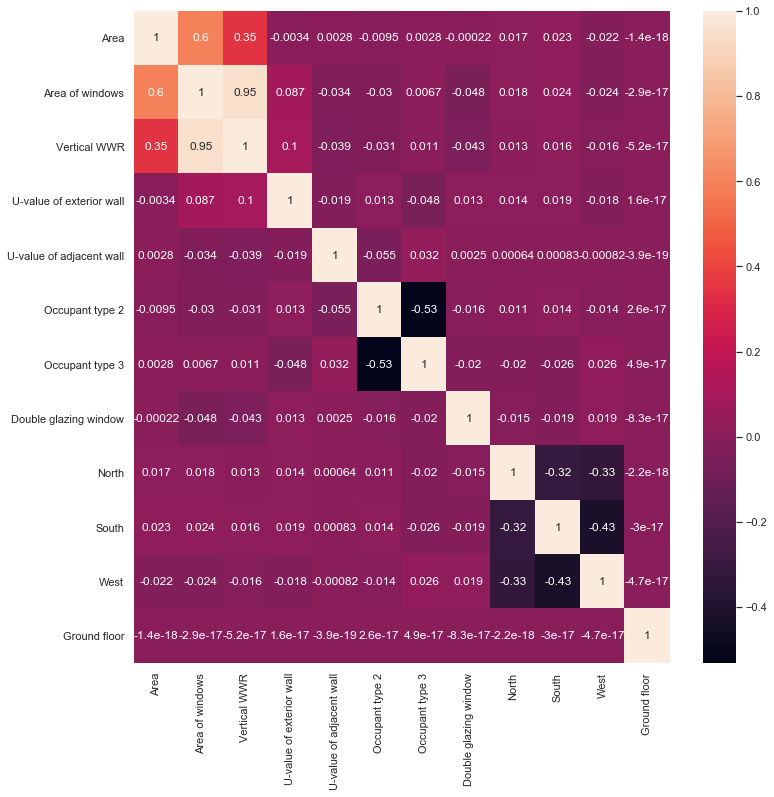

In [35]:
relation =Xr.corr()
relation_index=relation.index
sns.set(rc={'figure.figsize':(12,12),
            'axes.edgecolor':'black'})
sns.heatmap(Xr[relation_index].corr(),annot=True)

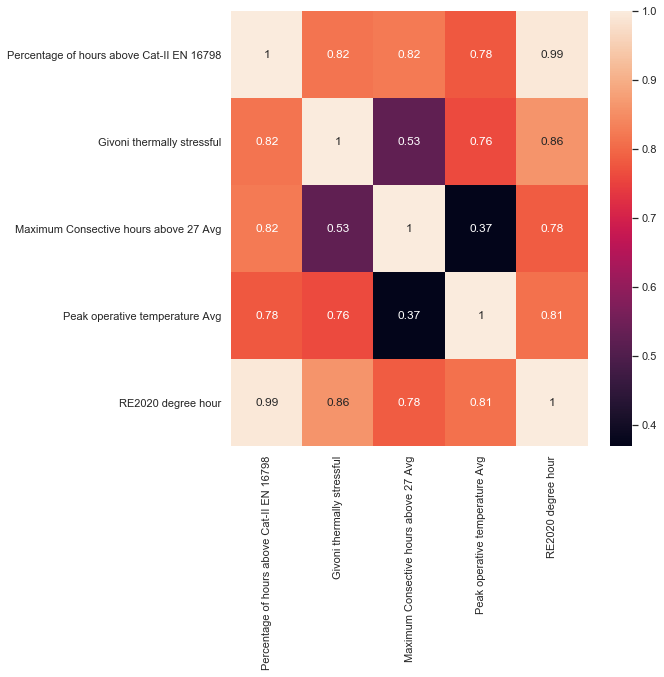

In [36]:
## for the outputs 
relation =y_true.corr()
relation_index=relation.index
sns.set(rc={'figure.figsize':(8,8),
            'axes.edgecolor':'black'})
sns.heatmap(y_true[relation_index].corr(),annot=True)

In [37]:
X_train, X_test, Y_train, Y_test = train_test_split(Xr,y_true, test_size=0.2,random_state=1)

In [38]:
Y_train.shape

(864, 5)

In [39]:
from sklearn import metrics

### Running multi-output regression without interactions

In [40]:
#Applying linear regression for a multi-output problem
LRegression=LinearRegression(normalize=False)
LRegression.fit(X_train, Y_train)
print(LRegression.score(X_test,Y_test))
print(np.mean((LRegression.predict(X_test) - Y_test) ** 2))
LRegression.get_params(deep=True)

0.6175187262851767
Percentage of hours above Cat-II EN 16798        15.710184
Givoni thermally stressful                        0.043364
Maximum Consective hours above 27 Avg          4475.352527
Peak operative temperature Avg                    0.341071
RE2020 degree hour                           126497.965954
dtype: float64


{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': False}

In [41]:
print('MAE:', metrics.mean_absolute_error(Y_test,LRegression.predict(X_test)))
print('MSE:', metrics.mean_squared_error(Y_test, LRegression.predict(X_test)))
print('RMSE:', np.sqrt(metrics.mean_squared_error(Y_test, LRegression.predict(X_test))))

MAE: 64.10311642490862
MSE: 26197.882619987195
RMSE: 161.857599821532


In [42]:
MLR_reg=pd.DataFrame(LRegression.predict(X_test),columns=[
    'Percentage of hours above Cat-II EN 16798',
    'Givoni thermally stressful',
    'Maximum Consective hours above 27 Avg',
    'Peak operative temperature Avg',
    'RE2020 degree hour'])

In [43]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import accuracy_score as acc

##### Feature importance 

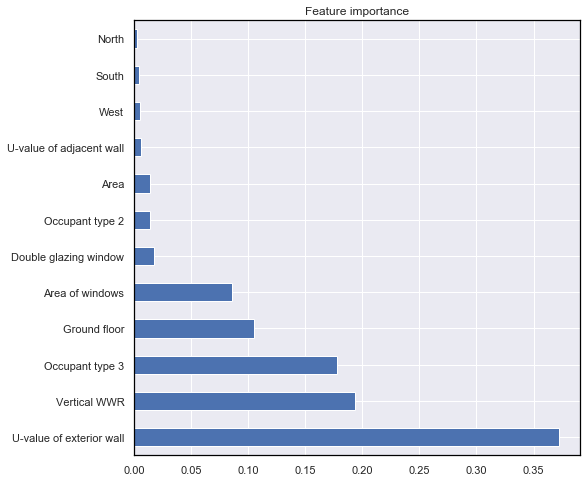

In [44]:
## First split data into Training and test data - this is done only on Xt where
# for feature importance evaluation
reg= ExtraTreesRegressor()
reg.fit(X_train,Y_train)
feat_importances = pd.Series(reg.feature_importances_, index=X_train.columns)
feat_importances.nlargest(15).plot(kind='barh',title='Feature importance')
plt.show()
print()

### Running regression with interactions

In [45]:
## Input and output parameters of training data for regression model 
Xb =df1[InputColumns]
y_true = df1[OutputColumns]
## Creating the interaction between input parameters of the regression
poly = PolynomialFeatures(interaction_only=True)
X_tr = poly.fit_transform(Xb)
Xt = pd.concat([Xb.reset_index(drop=True),
                pd.DataFrame(X_tr,columns=poly.get_feature_names(Xb.columns.tolist())).drop(columns=Xb.columns.insert(0,"1"))],axis=1)

In [46]:
Xt.shape

(1080, 78)

Looking at the shape of Xt. we notice that number of attributes increased to 78...as it previously demonstrated 
large number of attributes causes overfitting and model will not perform well. Therefore, we run a feature importance analysis and select 10 most important features

##### Feature importance of features with interaction to each other

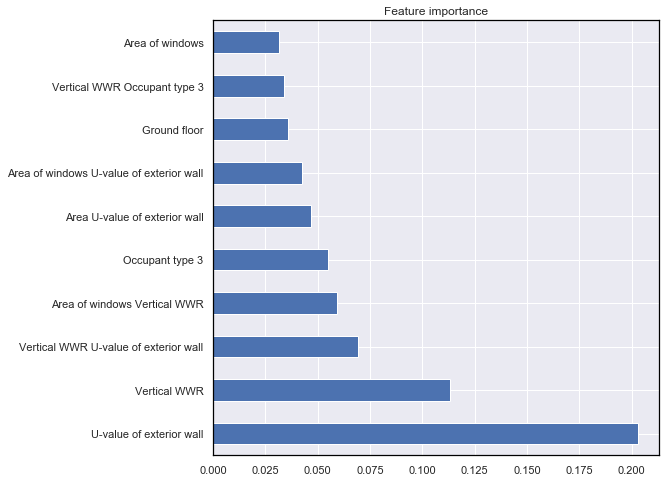

In [47]:
## First split data into Training and test data - this is done only on Xt where
# for feature importance evaluation we select each output separately
Yt = df1[OutputColumns]
Xt_train, Xt_test, Yt_train, Yt_test = train_test_split(Xt,Yt, test_size=0.2,random_state=1)

# Feature importance for Percentage of hours above Cat-II EN 16798
reg= ExtraTreesRegressor()
reg.fit(Xt_train,Yt_train)
feat_importances = pd.Series(reg.feature_importances_, index=Xt_train.columns)
feat_importances.nlargest(10).plot(kind='barh',title='Feature importance')
plt.show()
print()

In [48]:
Selected_features=feat_importances.nlargest(10).index.tolist()
Selected_features

['U-value of exterior wall',
 'Vertical WWR',
 'Vertical WWR U-value of exterior wall',
 'Area of windows Vertical WWR',
 'Occupant type 3',
 'Area U-value of exterior wall',
 'Area of windows U-value of exterior wall',
 'Ground floor',
 'Vertical WWR Occupant type 3',
 'Area of windows']

In [49]:
#Applying linear regression for the selected top 10 parameters
LRegression=LinearRegression(normalize=True)
LRegression.fit(Xt_train[Selected_features], Yt_train)
print(LRegression.score(Xt_test[Selected_features],Yt_test))
print(np.mean((LRegression.predict(Xt_test[Selected_features]) - Yt_test) ** 2))
LRegression.get_params(deep=True)

0.6376660197228893
Percentage of hours above Cat-II EN 16798        15.568355
Givoni thermally stressful                        0.028840
Maximum Consective hours above 27 Avg          5039.790547
Peak operative temperature Avg                    0.370425
RE2020 degree hour                           119169.076023
dtype: float64


{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'normalize': True}

In [50]:
print('MAE:', metrics.mean_absolute_error(Yt_test,LRegression.predict(Xt_test[Selected_features])))
print('MSE:', metrics.mean_squared_error(Yt_test, LRegression.predict(Xt_test[Selected_features])))
print('RMSE:', np.sqrt(metrics.mean_squared_error(Yt_test, LRegression.predict(Xt_test[Selected_features]))))

MAE: 63.53139854301327
MSE: 24844.966838321565
RMSE: 157.62286267645808


In [51]:
Interacing_params_reg=pd.DataFrame(LRegression.predict(Xt_test[Selected_features]),columns=[
    'Percentage of hours above Cat-II EN 16798',
    'Givoni thermally stressful',
    'Maximum Consective hours above 27 Avg',
    'Peak operative temperature Avg',
    'RE2020 degree hour'])

### Running regression with RIDGE regression

In [52]:
#from sklearn.linear_model import Ridge

In [53]:
#Alpha=[]
#Test_score=[]
#Train_score=[]
#for alpha in [0,0.001,0.005,0.01,0.05,0.1,0.5,1,5,10]:
#    RidgeModel=Ridge(alpha=alpha)
#    RidgeModel.fit(Xt_train[Selected_features], Yt_train)
#    test_score,train_score=RidgeModel.score(Xt_test[Selected_features],Yt_test),RidgeModel.score(Xt_train[Selected_features],Yt_train)
#    Alpha.append(alpha)
#    Test_score.append(test_score)
#    Train_score.append(train_score)

In [54]:
#width=10
#length=5
#plt.figure(figsize=(width,length))
#plt.plot(Alpha,Test_score,label='test data')
#plt.plot(Alpha,Train_score,label='training data')
#plt.xlabel('alpha')
#plt.ylabel('R^2')
#plt.legend()

In [55]:
## Training data with identified alpha , alpha =0 
#RidgeModel=Ridge(alpha=0)
#RidgeModel.fit(Xt_train[Selected_features], Yt_train)
#RidgePredict=RidgeModel.predict(Xt_test[Selected_features])
#print(np.mean((RidgeModel.predict(Xt_test[Selected_features]) - Y_test) ** 2))

In [56]:
#print('MAE:', metrics.mean_absolute_error(Yt_test,RidgePredict))
#print('MSE:', metrics.mean_squared_error(Yt_test, RidgePredict))
#print('RMSE:', np.sqrt(metrics.mean_squared_error(Yt_test, RidgePredict)))

In [57]:
#Ridge_OnInteracting_reg=pd.DataFrame(RidgePredict,columns=[
#    'Percentage of hours above Cat-II EN 16798',
#    'Givoni thermally stressful',
#    'Maximum Consective hours above 27 Avg',
#    'Peak operative temperature Avg',
#    'RE2020 degree hour'])

### Using DecisionTree 

In [58]:
from sklearn.tree import DecisionTreeRegressor

In [59]:
reg_decision_model=DecisionTreeRegressor()

In [60]:
## Using GridSearchCV identify the best parameters (hyper parameter tuning)
#parameters={"splitter":["best","random"],
#            "max_depth" : [1,3,5,7,9,11,12],
#            "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
#            "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
#            "max_features":["auto","log2","sqrt",None],
#            "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90]}

In [61]:
#tuning_model=GridSearchCV(reg_decision_model,param_grid=parameters,scoring='neg_mean_squared_error',cv=3,verbose=3)
#tuning_model.fit(Xr,y_true)
#tuning_model.best_params_
#print("Best score: " + str (tuning_model.best_score_))

In [62]:
#tuning_model.best_score_
print(-48585.453537505346)

-48585.453537505346


In [63]:
#tuning_model.best_params_
#{'max_depth': 12,
# 'max_features': None,
# 'max_leaf_nodes': 40,
# 'min_samples_leaf': 10,
# 'min_weight_fraction_leaf': 0.1,
# 'splitter': 'random'}

In [64]:
## Building decision model using tuned hyper parameters
tuned_DT_model= DecisionTreeRegressor(max_depth=12,max_features=None,max_leaf_nodes=40,min_samples_leaf=10,
                                         min_weight_fraction_leaf=0.1,splitter='random')
tuned_DT_model.fit(X_train,Y_train)

DecisionTreeRegressor(max_depth=12, max_leaf_nodes=40, min_samples_leaf=10,
                      min_weight_fraction_leaf=0.1, splitter='random')

In [65]:
tuned_pred=tuned_DT_model.predict(X_test)

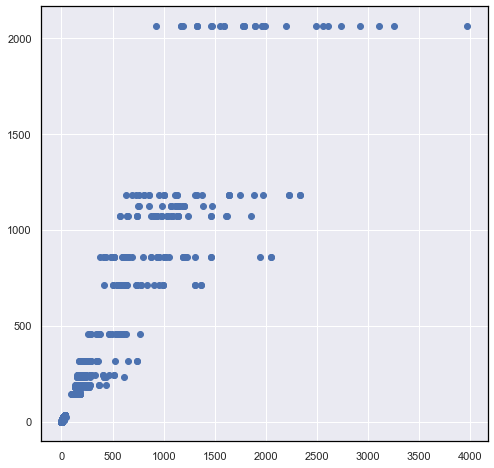

In [66]:
plt.scatter(Y_test,tuned_pred)

In [67]:
## Means squared error for each target variable
print(np.mean((tuned_DT_model.predict(X_test) - Y_test) ** 2))

Percentage of hours above Cat-II EN 16798        24.383293
Givoni thermally stressful                        0.033858
Maximum Consective hours above 27 Avg          7735.031851
Peak operative temperature Avg                    0.540643
RE2020 degree hour                           177692.400951
dtype: float64


In [68]:
## Printing average accuracy measures of the model
print('MAE:', metrics.mean_absolute_error(Y_test,tuned_pred))
print('MSE:', metrics.mean_squared_error(Y_test, tuned_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(Y_test, tuned_pred)))

MAE: 72.1008020544563
MSE: 37090.4781191304
RMSE: 192.58888368524907


In [69]:
DT_reg=pd.DataFrame(tuned_pred,columns=[
    'Percentage of hours above Cat-II EN 16798',
    'Givoni thermally stressful',
    'Maximum Consective hours above 27 Avg',
    'Peak operative temperature Avg',
    'RE2020 degree hour'])

In [70]:
#Re_data = pd.DataFrame(tuned_pred)

In [71]:
## Adding the output to VerData dataframe for comparison
#new_cols = {x: y for x, y in zip(Re_data.columns, VerData.columns)}
#VerData = VerData.append(Re_data.rename(columns=new_cols))

In [72]:
#VerData.info()

### Random Forest

In [73]:
from sklearn.ensemble import RandomForestRegressor

In [74]:
### Hyper prameter tuning of random forest regressor
#estimator = RandomForestRegressor()
#param_grid = {"n_estimators":[10,20,50,100,1000],
#              "max_features":["auto","sqrt","log2"],
#              "min_samples_split" : [2,4,8,10],
#              "bootstrap": [True, False],
#             }

In [75]:
#grid = GridSearchCV(estimator, param_grid, n_jobs=-1,cv=5)
#grid.fit(X_train, Y_train)
#print('Best score :', grid.best_score_)
#print('Best hyper prameters :',grid.best_params_)
print("Best score : 0.8473050095486284")
print("Best hyper prameters : {'bootstrap': False, 'max_features': 'sqrt', 'min_samples_split': 8, 'n_estimators': 20}")

Best score : 0.8473050095486284
Best hyper prameters : {'bootstrap': False, 'max_features': 'sqrt', 'min_samples_split': 8, 'n_estimators': 20}


In [76]:
tuned_RF_regressor=RandomForestRegressor(bootstrap=False, max_features='sqrt',min_samples_split=8, n_estimators=100)
tuned_RF_regressor.fit(X_train,Y_train)

RandomForestRegressor(bootstrap=False, max_features='sqrt', min_samples_split=8)

In [77]:
RF_regression=tuned_RF_regressor.predict(X_test)
## Means squared error for each target variable
print(np.mean((RF_regression - Y_test) ** 2))

Percentage of hours above Cat-II EN 16798        9.195906
Givoni thermally stressful                       0.010979
Maximum Consective hours above 27 Avg         1131.910122
Peak operative temperature Avg                   0.258528
RE2020 degree hour                           74288.988214
dtype: float64


In [78]:
## Printing average accuracy measures of the model
print('MAE:', metrics.mean_absolute_error(Y_test,RF_regression))
print('MSE:', metrics.mean_squared_error(Y_test, RF_regression))
print('RMSE:', np.sqrt(metrics.mean_squared_error(Y_test, RF_regression)))

MAE: 46.06017714093854
MSE: 15086.07274974215
RMSE: 122.82537502382051


In [79]:
RF_reg=pd.DataFrame(RF_regression,columns=[
    'Percentage of hours above Cat-II EN 16798',
    'Givoni thermally stressful',
    'Maximum Consective hours above 27 Avg',
    'Peak operative temperature Avg',
    'RE2020 degree hour'])

### Sklearn MultiOutput Regressor - Support Vector Machine (SVR)

In [80]:
from sklearn.multioutput import MultiOutputRegressor

In [81]:
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor

In [82]:
#for kernals in ['linear','poly','sigmoid','rbf']:
#    svr_reg = MultiOutputRegressor(SVR(kernel=kernals))
#    svr_reg.fit(X_train,Y_train)
#    Predicted=svr_reg.predict(X_test)
#    print(kernals,'Kernal : \n','MAE:', metrics.mean_absolute_error(Y_test,Predicted))
#    print('MSE:', metrics.mean_squared_error(Y_test, Predicted))
#    print('RMSE:', np.sqrt(metrics.mean_squared_error(Y_test, Predicted)))
#    print(np.mean((Predicted-Y_test)**2))

In [83]:
## Comparing kernals show that Linear kernal performs better 
svr_reg = MultiOutputRegressor(SVR(kernel='linear'))
svr_reg.fit(X_train,Y_train)
Predicted_SVR=svr_reg.predict(X_test)

print('MAE:', metrics.mean_absolute_error(Y_test,Predicted_SVR))
print('MSE:', metrics.mean_squared_error(Y_test, Predicted_SVR))
print('RMSE:', np.sqrt(metrics.mean_squared_error(Y_test, Predicted_SVR)))

print(np.mean((Predicted_SVR-Y_test)**2))

MAE: 71.80232939662476
MSE: 45934.117444985364
RMSE: 214.32246136367826
Percentage of hours above Cat-II EN 16798        17.786432
Givoni thermally stressful                        0.046028
Maximum Consective hours above 27 Avg          6472.330074
Peak operative temperature Avg                    0.364017
RE2020 degree hour                           223180.060675
dtype: float64


In [84]:
SVM_reg=pd.DataFrame(Predicted_SVR,columns=[
    'Percentage of hours above Cat-II EN 16798',
    'Givoni thermally stressful',
    'Maximum Consective hours above 27 Avg',
    'Peak operative temperature Avg',
    'RE2020 degree hour'])

### Sklearn MultiOutput Regressor - Gradient Boosting Regressor 

In [85]:
from sklearn.ensemble import GradientBoostingRegressor

In [86]:
## Hyper-parameter tuning og GBR 

In [87]:
### Model was tuned in two steps, firs number of estimators were tuned and then learning rate
##n_estimator=[50,100,500,750,1000,1250,1500]
#learning_r=[0.2,0.1,0.05,0.01,0.005]
#for learn_r in learning_r:
#    gbr = GradientBoostingRegressor(learning_rate=learn_r, n_estimators=100)
#    model = MultiOutputRegressor(estimator=gbr)
#    model.fit(X_train,Y_train)
#    GB_regres_predict = model.predict(X_test)
#
#    print('MAE:', metrics.mean_absolute_error(Y_test,GB_regres_predict))
#    print('MSE:', metrics.mean_squared_error(Y_test, GB_regres_predict))
#    print('RMSE:', np.sqrt(metrics.mean_squared_error(Y_test, GB_regres_predict)))
#
#    print(np.mean((GB_regres_predict-Y_test)**2))
#    print(model)

In [88]:
##Tuned model 
gbr = GradientBoostingRegressor(learning_rate=0.1,n_estimators=100)
model = MultiOutputRegressor(estimator=gbr)
model.fit(X_train,Y_train)
GB_regres_predict = model.predict(X_test)

print('MAE:', metrics.mean_absolute_error(Y_test,GB_regres_predict))
print('MSE:', metrics.mean_squared_error(Y_test, GB_regres_predict))
print('RMSE:', np.sqrt(metrics.mean_squared_error(Y_test, GB_regres_predict)))

print(np.mean((GB_regres_predict-Y_test)**2))

MAE: 42.545352663622666
MSE: 12615.314522069548
RMSE: 112.31791719075612
Percentage of hours above Cat-II EN 16798        7.635439
Givoni thermally stressful                       0.010815
Maximum Consective hours above 27 Avg         1062.176920
Peak operative temperature Avg                   0.220893
RE2020 degree hour                           62006.528542
dtype: float64


In [89]:
GB_Reg=pd.DataFrame(GB_regres_predict,columns=[
    'Percentage of hours above Cat-II EN 16798',
    'Givoni thermally stressful',
    'Maximum Consective hours above 27 Avg',
    'Peak operative temperature Avg',
    'RE2020 degree hour'])

In [90]:
from sklearn.metrics import r2_score
for items in OutputColumns:
    print('{}:'.format(items),r2_score(GB_Reg[items], Y_test[items]))

Percentage of hours above Cat-II EN 16798: 0.803711605866964
Givoni thermally stressful: 0.8659882679001306
Maximum Consective hours above 27 Avg: 0.8678193350896585
Peak operative temperature Avg: 0.7645501215811193
RE2020 degree hour: 0.7892096826375126


### Plotting simulation to predicted values on line distribution plots 

In [91]:
OutputColumns

['Percentage of hours above Cat-II EN 16798',
 'Givoni thermally stressful',
 'Maximum Consective hours above 27 Avg',
 'Peak operative temperature Avg',
 'RE2020 degree hour']

In [92]:
#for items in OutputColumns:
#    fig = plt.figure(figsize=(6,6))
#    sns.set(rc={'axes.edgecolor':'black',
#                'axes.facecolor':'w',
#                'axes.grid':True})
#
#    sns.kdeplot(MLR_reg[items],label='Multiple linear regression')
#    sns.kdeplot(Interacing_params_reg[items],label='Multiple linear regression with interaction')
#    sns.kdeplot(DT_reg[items],label='Decision Tree')
#    sns.kdeplot(Y_test[items],label='Test data',color='black')
#    sns.kdeplot(SVM_reg[items],label='Support Vector Machine (SVM)')
#    sns.kdeplot(GB_Reg[items],label='Gradient Boosting Regression')
#    sns.kdeplot(RF_reg[items],label='Random Forest Regressor')
#
#    fig.legend(loc='lower center',bbox_to_anchor=(0.5,-0.06),ncol=2)
#    plt.show()

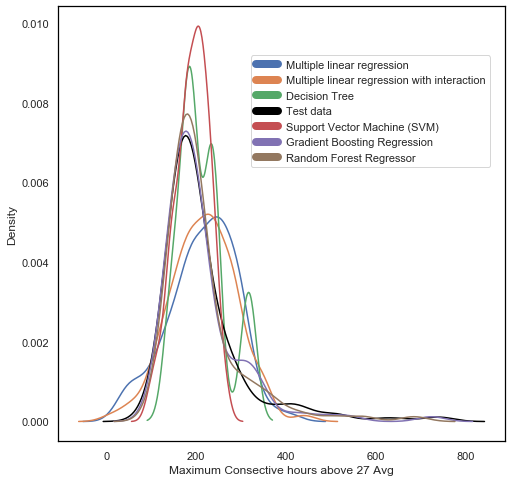

In [93]:
fig = plt.figure(figsize=(8,8))
sns.set(rc={'axes.edgecolor':'black',
            'axes.facecolor':'w',
            'axes.grid':True})

sns.kdeplot(MLR_reg['Maximum Consective hours above 27 Avg'],label='Multiple linear regression')
sns.kdeplot(Interacing_params_reg['Maximum Consective hours above 27 Avg'],label='Multiple linear regression with interaction')
sns.kdeplot(DT_reg['Maximum Consective hours above 27 Avg'],label='Decision Tree')
sns.kdeplot(Y_test['Maximum Consective hours above 27 Avg'],label='Test data',color='black')
sns.kdeplot(SVM_reg['Maximum Consective hours above 27 Avg'],label='Support Vector Machine (SVM)')
sns.kdeplot(GB_Reg['Maximum Consective hours above 27 Avg'],label='Gradient Boosting Regression')
sns.kdeplot(RF_reg['Maximum Consective hours above 27 Avg'],label='Random Forest Regressor')

leg = plt.legend(loc='upper center', bbox_to_anchor=(0.7, 0.9),ncol=1)
for l in leg.legendHandles:
    l.set_linewidth(8)

plt.show()

## Predicting RE2020 situation directly (categorical output)

In [94]:
Y_cat=df1[CategoricalOutput]
XC_train, XC_test, YC_train, YC_test = train_test_split(Xr,Y_cat, test_size=0.2,random_state=1)

In [95]:
YC_test.shape

(216, 1)

In [96]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

### Multinomial Logistic regression to predict RE2020 situation

In [97]:
from sklearn.linear_model import LogisticRegression

In [98]:
### hyper-parameter tuning of logistic regression 
#parameters = {'C':[0.01,0.1,1,10,100],
#             'penalty':['l2'],
#             'solver':['lbfgs','saga']}
#MLogReg = LogisticRegression()
#Grid_MLogR=GridSearchCV(MLogReg,parameters,'accuracy',cv=10)
#Grid_LogR=Grid_MLogR.fit(XC_train, YC_train)

In [99]:
##printing selected hyper-parameters
#print('tuned hyper-parameters :',Grid_LogR.best_params_)
#print('Accuracy ',Grid_LogR.best_score_)
print("tuned hyper-parameters : {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}")
print('Accuracy  0.8901095963646085')

tuned hyper-parameters : {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy  0.8901095963646085


In [100]:
MLogReg = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='l2', C=10)
Grid_LogR=MLogReg.fit(XC_train, YC_train)
##Prediction 
LogReg_predict=Grid_LogR.predict(XC_test)
## printing accuracy level
print('Classification report ',classification_report(YC_test,LogReg_predict))

Classification report                  precision    recall  f1-score   support

   Comfortable       1.00      0.80      0.89        10
Not_regulatory       0.62      0.55      0.58        33
       at_risk       0.91      0.94      0.92       173

      accuracy                           0.87       216
     macro avg       0.84      0.76      0.80       216
  weighted avg       0.87      0.87      0.87       216



C:\Users\obaidullah.yaqubi\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\obaidullah.yaqubi\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [101]:
##classes 
Grid_LogR.classes_

array(['Comfortable', 'Not_regulatory', 'at_risk'], dtype=object)

In [102]:
### Counting number of unique instances
#unique, counts = np.unique(LogReg_predict, return_counts=True)
#dict(zip(unique, counts))

[Text(0, 0.5, 'True labels'), Text(0.5, 0, 'Predicted labels')]

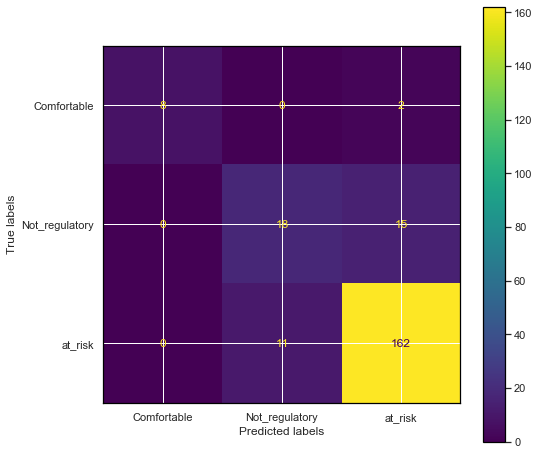

In [103]:
cm = confusion_matrix(YC_test, LogReg_predict,labels=Grid_LogR.classes_)
cmd = ConfusionMatrixDisplay(cm, display_labels=Grid_LogR.classes_)
cmd.plot()
cmd.ax_.set(xlabel='Predicted labels', ylabel='True labels')

### Gradient Boosting Classifier to predict RE2020 situation

In [104]:
from sklearn.ensemble import GradientBoostingClassifier

In [105]:
### hyper parameter tunning with the help of GridSearchCV : for the moment only number of trees and learning rate
#p_test3 = {'learning_rate':[0.05,0.01,0.005,0.001], 
#           'n_estimators':[500,750,1000,1250,1500,1750]}
#
#tuning = GridSearchCV(estimator =GradientBoostingClassifier(max_depth=4, min_samples_split=2, min_samples_leaf=1,
#                                                            subsample=1,max_features='sqrt', random_state=10), 
#                      param_grid = p_test3, scoring='accuracy',n_jobs=4,iid=False, cv=5)
#
#tuning.fit(XC_train, YC_train)
#tuning.best_params_, tuning.best_score_

C:\Users\obaidullah.yaqubi\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


Accuracy of the GBM on test data: 0.847
Classification report                  precision    recall  f1-score   support

   Comfortable       1.00      0.50      0.67        10
Not_regulatory       0.69      0.27      0.39        33
       at_risk       0.85      0.98      0.91       173

      accuracy                           0.85       216
     macro avg       0.85      0.58      0.66       216
  weighted avg       0.84      0.85      0.82       216



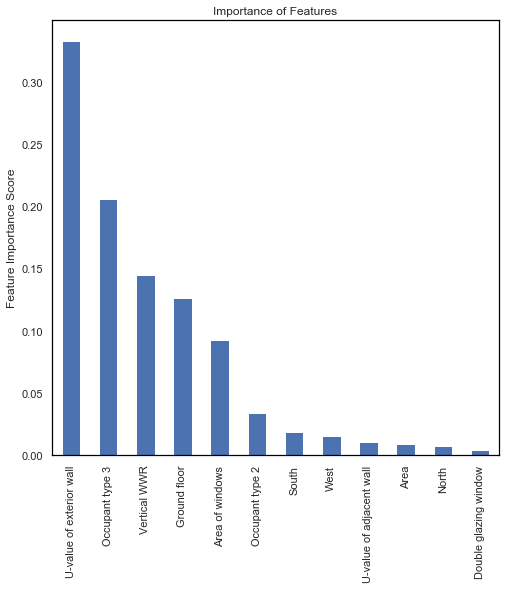

In [106]:
## Using tune parameters to build a Gradient Boosting Classifier
TunedModel = GradientBoostingClassifier(learning_rate=0.001, n_estimators=1750,max_depth=3, 
                                      min_samples_split=2, min_samples_leaf=1, subsample=1,
                                      max_features='sqrt', random_state=10)

TunedModel.fit(XC_train, YC_train)

##Plotting the importance of parameters on classification 
predictors=list(XC_train)
feat_imp = pd.Series(TunedModel.feature_importances_, predictors).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')

print('Accuracy of the GBM on test data: {:.3f}'.format(TunedModel.score(XC_test, YC_test)))
##predicting 
pred=TunedModel.predict(XC_test)
print('Classification report ',classification_report(YC_test,pred))

[Text(0, 0.5, 'True labels'), Text(0.5, 0, 'Predicted labels')]

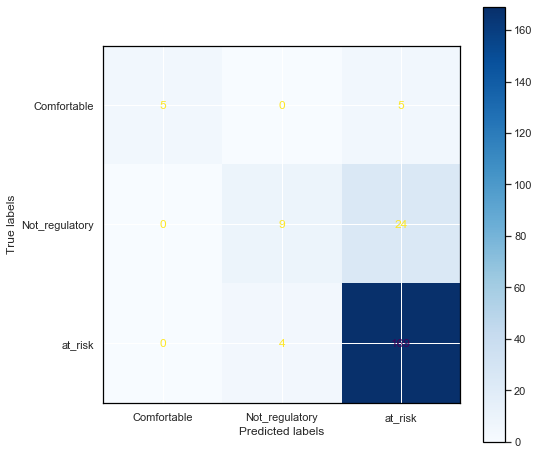

In [107]:
cm = confusion_matrix(YC_test, pred,labels=TunedModel.classes_)
cmd = ConfusionMatrixDisplay(cm, display_labels=TunedModel.classes_)
cmd.plot()

cmd.im_.set(cmap='Blues')
cmd.ax_.set(xlabel='Predicted labels', ylabel='True labels')

### Using selected model in prediction of validation model 

#### For continuous dependent variables (Gradient Boosting Regressor) 

This section requires the selected model to be retrained with the whole dataset and then used for prediction

In [108]:
## Validation input and outputs
X_validation=df_validation[InputColumns]
Y_validation=df_validation[OutputColumns]

In [109]:
## Training tuned gradient boosting multioutput regressor 
gbr = GradientBoostingRegressor(learning_rate=0.1,n_estimators=100)
model = MultiOutputRegressor(estimator=gbr)
model.fit(Xr,y_true)

MultiOutputRegressor(estimator=GradientBoostingRegressor())

In [110]:
GB_regres_predict = model.predict(X_validation)

print('MAE:', metrics.mean_absolute_error(Y_validation,GB_regres_predict))
print('MSE:', metrics.mean_squared_error(Y_validation, GB_regres_predict))
print('RMSE:', np.sqrt(metrics.mean_squared_error(Y_validation, GB_regres_predict)))

print(np.mean((GB_regres_predict-Y_validation)**2))

MAE: 149.81422264043198
MSE: 115256.78750588876
RMSE: 339.4949005594764
Percentage of hours above Cat-II EN 16798        56.188765
Givoni thermally stressful                        0.152434
Maximum Consective hours above 27 Avg           950.394655
Peak operative temperature Avg                    3.677927
RE2020 degree hour                           575273.523748
dtype: float64


In [111]:
Predicted_GB=pd.DataFrame(GB_regres_predict,columns=Y_validation.columns.tolist())

In [112]:
## Last five rows indicating average of zones for ground floor (values =3)
#
d = {}
for items in OutputColumns:
    d[items]=[Y_validation[items].groupby(Y_validation[items].index //6).mean().values[0],
              Predicted_GB[items].groupby(Predicted_GB[items].index //6).mean().values[0]]
    
d=pd.DataFrame(d)
d=d.T
d=d.rename(columns={0:'Simulated',1:'Predicted'})
d

,Simulated,Predicted
Percentage of hours above Cat-II EN 16798,10.242130,14.023646
Givoni thermally stressful,0.036661,0.142462
Maximum Consective hours above 27 Avg,185.153306,210.037079
Peak operative temperature Avg,32.000000,32.864467
RE2020 degree hour,824.430025,1233.233124


KeyError: 'Percentage of hours above Cat-II EN 16798'

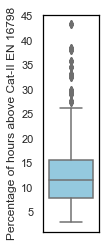

In [117]:
## Ground Floor
fig, axs = plt.subplots(1,1)
for items in OutputColumns:
    
    sns.set(rc={'figure.figsize':(1,4),
                'axes.edgecolor':'black',
                'axes.facecolor':'w',
                'axes.grid':True})
    b = sns.boxplot(data = df1,
                    y = items,
                    color='skyblue')
    name_of_zone='Middle Floor'

    plt.axhline(Y_validation[items].groupby(Y_validation[items].index //6).mean().values[0],
            color='blue',
            ls='--',
            lw=2.5,label='Simulated value for {}'.format(name_of_zone))

    plt.axhline(Predicted_GB[items].groupby(Predicted_GB[items].index //6).mean().values[0],
            color='red',
            ls='--',
            lw=2.5,label='Surrogate model prediction for {}'.format(name_of_zone)) 
    
    plt.legend(loc='lower center', bbox_to_anchor=(4.1, 0),ncol=1)
    plt.show()

#### Predicting RE2020 situation for each zone Using multinomial logistic regression

In [114]:
Y_cat=df1[CategoricalOutput]

## Simulated results
X_validation=df_validation[InputColumns]
Y_validation=df_validation[CategoricalOutput]

## Re-training model with the whole data
MLogReg = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='l2', C=10)
Grid_LogR=MLogReg.fit(Xr,Y_cat)

##Predicting 
LogReg_predict=Grid_LogR.predict(X_validation)

## printing accuracy level
print('Classification report ',classification_report(Y_validation,LogReg_predict))

Classification report                precision    recall  f1-score   support

     at_risk       1.00      1.00      1.00        20

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



C:\Users\obaidullah.yaqubi\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\obaidullah.yaqubi\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[Text(0, 0.5, 'Simulated labels'),
 Text(0.5, 0, 'Lables predicted by Surrogate model')]

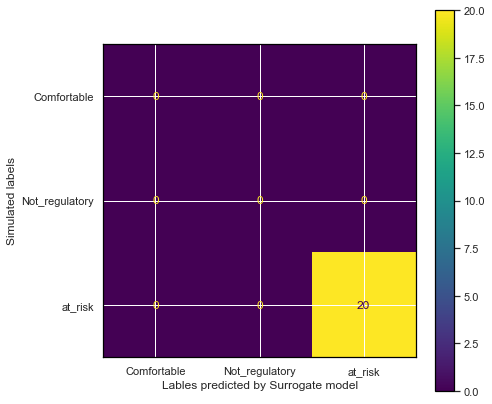

In [115]:
cm = confusion_matrix(Y_validation, LogReg_predict,labels=Grid_LogR.classes_)
cmd = ConfusionMatrixDisplay(cm, display_labels=Grid_LogR.classes_)

fig, ax = plt.subplots(figsize=(7,7))
cmd.plot(ax=ax)

cmd.im_.set()
cmd.figure_.set(frameon=False, facecolor='b')
cmd.ax_.set(xlabel='Lables predicted by Surrogate model', ylabel='Simulated labels')